# American Basket Option Pricing with Longstaff-Schwartz Method

This notebook demonstrates how to price American basket options using the Longstaff-Schwartz method. We'll simulate price paths for multiple assets using correlated Geometric Brownian Motion (GBM), calculate the basket price as a weighted sum of the assets, and then apply the Longstaff-Schwartz algorithm to price American and European options.

The Longstaff-Schwartz method uses regression to estimate the continuation value at each exercise date, allowing us to make optimal exercise decisions for American options.

## 1. Import Required Libraries and Classes

In [35]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal
from numpy.polynomial import Polynomial

# Import directly from the module - reload if you've made changes
import importlib
import longstaff_schwartz
importlib.reload(longstaff_schwartz)

# Import specific classes from longstaff_schwartz module
from longstaff_schwartz import (
    CorrelatedGBM,
    PolynomialBasis,
    LSMOptionPricer
)

# Configure matplotlib for better visualization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['lines.linewidth'] = 0.8

## 2. Set Simulation Parameters

Let's define the key parameters for our basket option pricing model:
- Number of assets in the basket
- Initial price for each asset
- Volatility for each asset
- Risk-free rate (used as drift for risk-neutral pricing)
- Time horizon
- Number of time steps
- Number of Monte Carlo simulations

In [36]:
# Parameters for the basket of assets
n_assets = 30  # Using 10 assets for faster execution in the notebook
S0 = [100] * n_assets  # All assets start at price 100
sigma = [0.2 + i * 0.01 for i in range(n_assets)]  # Different volatilities from 0.2 to 0.29

# Time and simulation parameters
T = 3 / 12  # 3 months in years
step = 60   # 60 time steps (approximately daily for 3 months)
N = 5000     # Number of simulation paths

# Risk-free rate and option strike price
r = 0.03    # 3% risk-free rate (used as drift in risk-neutral pricing)
K = 100     # Strike price (at-the-money)

print(f"Simulating {n_assets} assets over {T*12} months with {step} time steps")
print(f"Running {N} Monte Carlo simulations")
print(f"Risk-free rate: {r*100}%, Strike price: ${K}")

Simulating 30 assets over 3.0 months with 60 time steps
Running 5000 Monte Carlo simulations
Risk-free rate: 3.0%, Strike price: $100


## 3. Build Covariance Matrix

We'll create a block correlation structure:
- First group of assets: High correlation (0.7)
- Second group of assets: Medium correlation (0.4)
- Third group of assets: Low correlation (0.2)

Then we'll convert this correlation matrix to a covariance matrix using the volatilities.

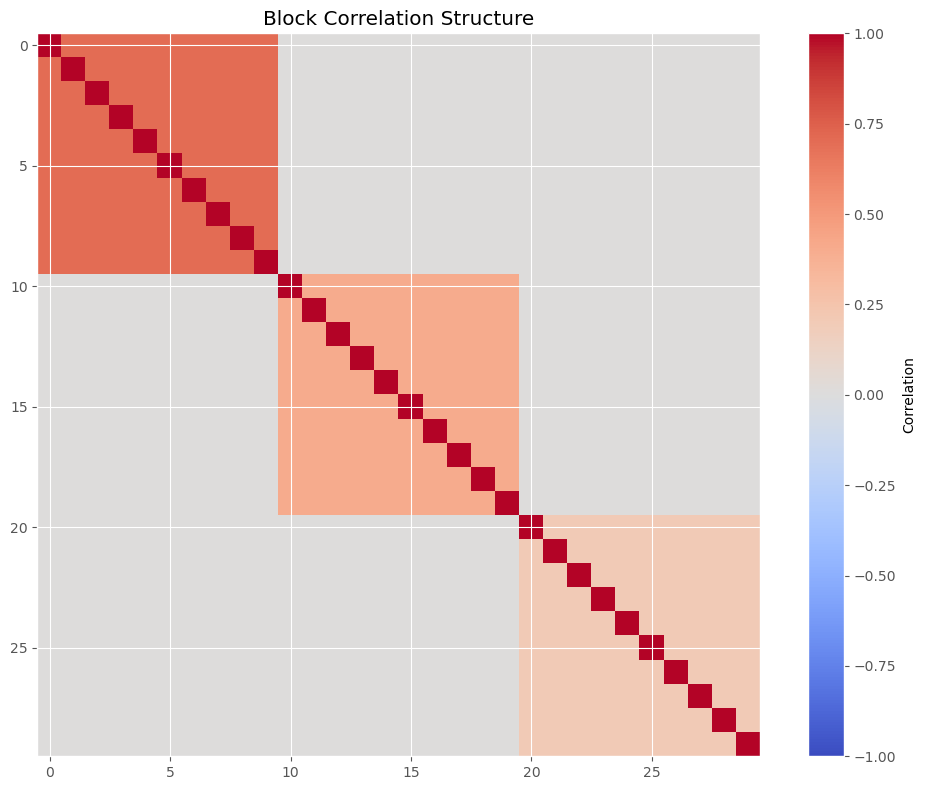

In [37]:
# Create correlation matrix (block correlation structure)
base_corr = np.eye(n_assets)

# Determine block sizes based on number of assets
block1 = n_assets // 3
block2 = block1 * 2

# First block: high correlation (0.7)
base_corr[:block1, :block1] = 0.7
np.fill_diagonal(base_corr[:block1, :block1], 1.0)

# Second block: medium correlation (0.4)
base_corr[block1:block2, block1:block2] = 0.4
np.fill_diagonal(base_corr[block1:block2, block1:block2], 1.0)

# Third block: low correlation (0.2)
base_corr[block2:, block2:] = 0.2
np.fill_diagonal(base_corr[block2:, block2:], 1.0)

# Build covariance matrix
cov = np.zeros((n_assets, n_assets))
for i in range(n_assets):
    for j in range(n_assets):
        cov[i, j] = base_corr[i, j] * sigma[i] * sigma[j]

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(base_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Block Correlation Structure')
plt.tight_layout()
plt.show()

## 4. Simulate Correlated GBM Paths

Now let's use the `CorrelatedGBM` class to simulate price paths for our basket of assets under the risk-neutral measure. For option pricing, we use the risk-free rate (r) as the drift parameter to ensure risk-neutral pricing.

Using equal weights for all assets: 0.0333 each

Using risk-neutral pricing: using risk-free rate (r = 0.03) for drift

Generated paths shape: (5000, 61, 30)
  - 5000 simulation paths
  - 61 time steps
  - 30 assets

Generated paths shape: (5000, 61, 30)
  - 5000 simulation paths
  - 61 time steps
  - 30 assets


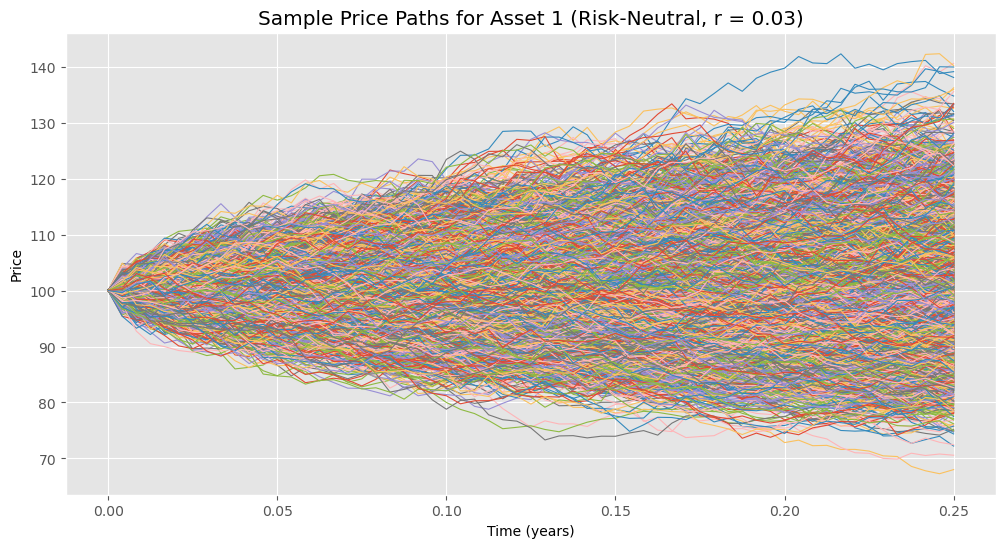

In [44]:
# Create equal weights for the basket
weights = np.ones(n_assets) / n_assets
print(f"Using equal weights for all assets: {weights[0]:.4f} each")

# Create the simulator using risk-free rate for risk-neutral pricing
print("\nUsing risk-neutral pricing: using risk-free rate (r = 0.03) for drift")

# Create the simulator
gbm_sim = CorrelatedGBM(S0, r, cov, T, step, N, weights)

# Generate paths
paths = gbm_sim.generate_paths()

# Print shape information
print(f"\nGenerated paths shape: {paths.shape}")
print(f"  - {N} simulation paths")
print(f"  - {step + 1} time steps")
print(f"  - {n_assets} assets")

# Display a few paths for the first asset
plt.figure(figsize=(12, 6))
for i in range(len(paths)):  # Plot first 5 paths
    plt.plot(np.linspace(0, T, step+1), paths[i, :, 0])
plt.title(f'Sample Price Paths for Asset 1 (Risk-Neutral, r = {r})')
plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 5. Plot Basket Price Paths

Next, we'll look at the basket price paths, which represent the weighted average of all assets in our basket.

Basket paths shape: (5000, 61)
Final basket price statistics:
  - Mean: $100.83
  - Std Dev: $6.69
  - Min: $79.33
  - Max: $127.61


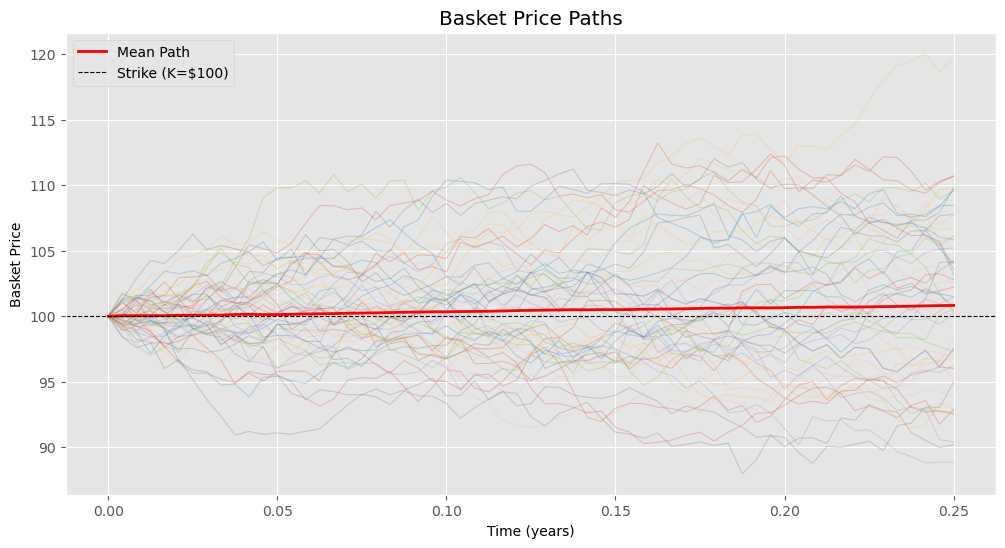

In [39]:
# Get basket price paths
basket_paths = gbm_sim.get_basket_paths()
print(f"Basket paths shape: {basket_paths.shape}")

# Calculate some statistics on final basket prices
final_prices = basket_paths[:, -1]
print(f"Final basket price statistics:")
print(f"  - Mean: ${np.mean(final_prices):.2f}")
print(f"  - Std Dev: ${np.std(final_prices):.2f}")
print(f"  - Min: ${np.min(final_prices):.2f}")
print(f"  - Max: ${np.max(final_prices):.2f}")

# Plot a sample of basket paths
plt.figure(figsize=(12, 6))
# Plot 50 random paths with low opacity
for i in np.random.choice(N, 50):
    plt.plot(np.linspace(0, T, step+1), basket_paths[i, :], alpha=0.3)
    
# Add the mean path
mean_path = np.mean(basket_paths, axis=0)
plt.plot(np.linspace(0, T, step+1), mean_path, 'r-', linewidth=2, label='Mean Path')

# Add the strike price
plt.axhline(y=K, color='k', linestyle='--', label=f'Strike (K=${K})')

plt.title('Basket Price Paths')
plt.xlabel('Time (years)')
plt.ylabel('Basket Price')
plt.legend()
plt.grid(True)
plt.show()

## 6. Price American Basket Put Option (Longstaff-Schwartz)

Now we'll price an American basket put option using the Longstaff-Schwartz method. This option can be exercised at any time point prior to maturity.

In [40]:
# Price the American basket put option using the LSMOptionPricer class
pricer = LSMOptionPricer(
    S0=S0, cov=cov, T=T, step=step, N=N,
    r=r, K=K, weights=weights, option="put"
)

# Simulate paths
pricer.simulate_paths()

# Price American option (allowing exercise at any time step)
american_price = pricer.price(basis=PolynomialBasis(degree=3))
print(f"American basket put option price: ${american_price:.4f}")

American basket put option price: $2.3573


## 7. Price European Basket Put Option

For comparison, we'll also price a European basket put option. This option can only be exercised at maturity.

In [41]:
# Price the European basket put option (exercise only at maturity)
european_price = pricer.price(exercise_grid=(step,))
print(f"European basket put option price: ${european_price:.4f}")

# We can also compute the European option price analytically for a basket
# But for a basket option, this is complex due to the basket distribution
# Instead, we can use the Monte Carlo estimate as our benchmark

European basket put option price: $2.2831


## 8. Calculate Early Exercise Premium

The difference between the American and European option prices represents the early exercise premium - the additional value from the ability to exercise the option before maturity.

Early exercise premium: $0.0742
Premium as percentage of European price: 3.25%


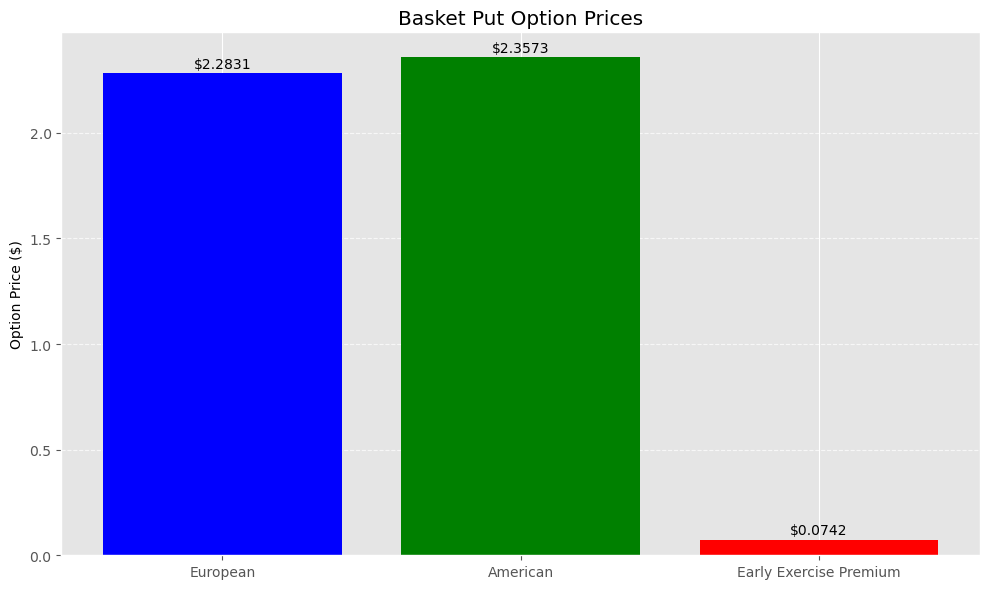

In [42]:
# Calculate the early exercise premium
early_exercise_premium = american_price - european_price
premium_percentage = (early_exercise_premium / european_price) * 100

print(f"Early exercise premium: ${early_exercise_premium:.4f}")
print(f"Premium as percentage of European price: {premium_percentage:.2f}%")

# Create a bar chart comparing the option prices
labels = ['European', 'American', 'Early Exercise Premium']
values = [european_price, american_price, early_exercise_premium]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.title('Basket Put Option Prices')
plt.ylabel('Option Price ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'${height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Volatility: 0.15, American: $0.9000, European: $0.8392, Premium: $0.0608
Volatility: 0.20, American: $1.3563, European: $1.2874, Premium: $0.0689
Volatility: 0.20, American: $1.3563, European: $1.2874, Premium: $0.0689
Volatility: 0.25, American: $1.7821, European: $1.7107, Premium: $0.0714
Volatility: 0.25, American: $1.7821, European: $1.7107, Premium: $0.0714
Volatility: 0.30, American: $2.0911, European: $2.0027, Premium: $0.0883
Volatility: 0.30, American: $2.0911, European: $2.0027, Premium: $0.0883
Volatility: 0.35, American: $2.4818, European: $2.3896, Premium: $0.0922
Volatility: 0.35, American: $2.4818, European: $2.3896, Premium: $0.0922


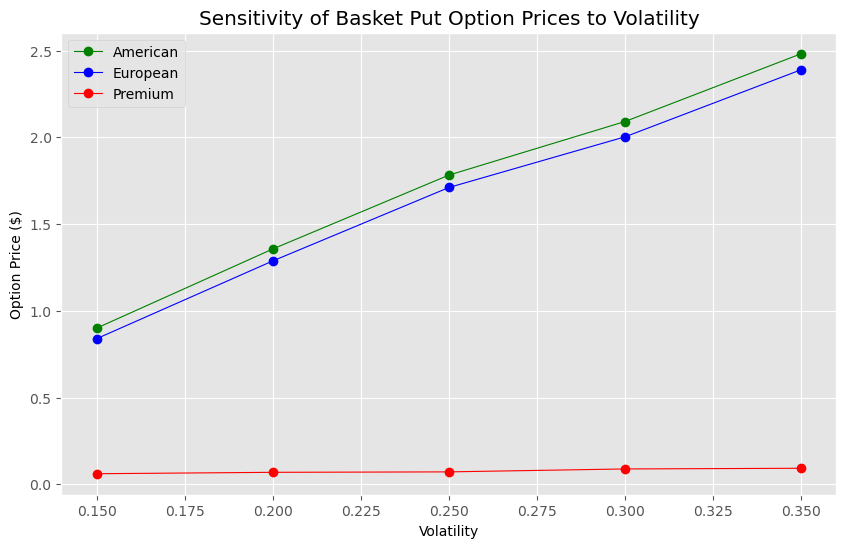

In [43]:
# Bonus: Quick sensitivity analysis of option prices to volatility
if True:  # Set to True to run this cell (it may take some time)
    volatility_levels = np.linspace(0.15, 0.35, 5)  # Different volatility levels
    american_prices = []
    european_prices = []
    
    for vol_level in volatility_levels:
        # Update volatilities for all assets
        new_sigma = [vol_level] * n_assets
        
        # Build new covariance matrix
        new_cov = np.zeros((n_assets, n_assets))
        for i in range(n_assets):
            for j in range(n_assets):
                new_cov[i, j] = base_corr[i, j] * new_sigma[i] * new_sigma[j]
        
        # Create pricing object
        sensitivity_pricer = LSMOptionPricer(
            S0=S0, cov=new_cov, T=T, step=step, N=N,
            r=r, K=K, weights=weights, option="put"
        )
        
        # Price American option
        sensitivity_pricer.simulate_paths()
        am_price = sensitivity_pricer.price()
        american_prices.append(am_price)
        
        # Price European option
        eu_price = sensitivity_pricer.price(exercise_grid=(step,))
        european_prices.append(eu_price)
        
        print(f"Volatility: {vol_level:.2f}, American: ${am_price:.4f}, European: ${eu_price:.4f}, Premium: ${am_price-eu_price:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(volatility_levels, american_prices, 'g-o', label='American')
    plt.plot(volatility_levels, european_prices, 'b-o', label='European')
    plt.plot(volatility_levels, np.array(american_prices) - np.array(european_prices), 'r-o', label='Premium')
    plt.xlabel('Volatility')
    plt.ylabel('Option Price ($)')
    plt.title('Sensitivity of Basket Put Option Prices to Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()